        Aerosol- und Nanotechnologie II | Florian Möller | Matr.-Nr. 4223486 | Abgabe: 01.05.22

# Task 2

The aim of the previous task was to determine particle distributions in a CSTR in steady state. In this task, the temporal dependency is also to be taken into account. For this Case the mass balance is given by
$$
\frac{\partial n(v_\mathrm{p}, t)}{\partial t} = -B \Delta n + Q n_0(v_\mathrm{p, min}) - Q n(v_\mathrm{p}, t)
\label{eq:mass balance}\tag{1}
$$
where $Q$ is the flow, $B$ the volume of the CSTR, $n_0(v_\mathrm{p, min}$ the constant particle distribution at the start, $n(v_\mathrm{p}, t)$ particle distribuiton depends on the volume $v_\mathrm{p}$ and the time $t$ and the net rate of formation $\Delta n$.

The disretization of this equation looks like

$$
n^{n}_{i} = \frac{n^{n - 1}_{i} + Q \cdot n^{0} \cdot \Delta t - B \cdot \Delta n \cdot \Delta t}{1 + Q \cdot \Delta t}.
$$

For a better overview, $\Delta n \cdot \Delta t$ is summarised in the form $\Delta n_{formed}$. 

This model uses for $\Delta n_{formed}$ the model from Hounslow et al. (1988) which is given by

$$
\dfrac{\mathrm{d} N_i}{\mathrm{d} t} = \,  N_{i-1} \sum_{j=1}^{i-2} 2^{j-i+1} \, \beta_{i-1,j} \, N_j
+ \frac{1}{2} \, \beta_{i-1,i-1} \, N_{i-1}^2 \\
 - N_{i} \sum_{j=1}^{i-1} 2^{j-i} \, \beta_{i,j} \, N_j
- N_{i} \sum_{j=i}^{\infty} \beta_{i,j} \, N_j
\label{eq:dndt}
$$

with the Continuum, coagulation coefficient $\beta$ which is given by

$$
\beta (v_i, v_j) = \frac{2 k_B T}{3 \mu} \left( \frac{1}{v_i^\frac{1}{3}} + \frac{1}{v_j^\frac{1}{3}} \right) \left( v_i^\frac{1}{3} + v_j^\frac{1}{3} \right).
\label{eq:beta}
$$

For the model used for solving this task, Hounslow's model was used and extended.

In [128]:
import numpy as np
from matplotlib import pyplot as plt

In [129]:
# variable declarations
t_total = 2e-0                           # [s], change from 2e-4 to 2e-0 or any 
                                         # other number   
nt = 1000                                # number of iteration steps 
dt = t_total / nt                        # [s], small time step during the interation
dp_min = 0.5e-9                          # [m]
dp_max = 1000e-9                         # [m]
vp_min = np.pi/6 * (dp_min)**3           # [m^3]
vp_max = np.pi/6 * (dp_max)**3           # [m^3]

In [130]:
# Initialization
vp_num = int(np.log(vp_max / vp_min) // np.log(2) + 2)

vp = np.zeros((vp_num))
for i in range(vp_num): 
    vp[i] = vp_min * 2**i 
    
n = np.zeros((vp_num))


In [131]:
#
#--------------------------------- Berechnung beta Koagulation im Kontibereich
#

k_B = 1.380649e-23                       # [J / K = N m / K = kg m^2 / (s^2 * K)]
mu = 17.2e-6                             # dynamische Viskosität Luft [Pa*s = N * s /m^2 = kg / ( m * s)] 
T = 293                                  # [K]

beta_pre = (2*k_B*T)/(3*mu)              # [kg m^2 *K *m * s/ (s^2 * K * kg) = m^3/s]


beta_n = np.zeros((vp_num, vp_num))
for i in range(vp_num): 
    for j in range(vp_num): 
        beta_n[i,j] = beta_pre * (1/vp[i]**(1/3) + 1/vp[j]**(1/3)) *(vp[i]**(1/3) + vp[j]**(1/3))
        # [m^3 /s * 1/m * m = m^3/s]


In [132]:
# Initial conditions
n_0 = np.zeros((vp_num))
start_bin = 1                 # this is an easy way to select a starting size
n_0[start_bin] = 1e17         # [#/m^3]
#n_0[6] = 1e17                # try to use these additional particles as starting condition
n = n_0.copy()                # copy the initial condition to our interation array 


Q = 1
B = 1
N_0 = 1e17

n_zeit = np.zeros((nt))

## Numerical solution

In [133]:

n_formed = np.zeros((vp_num))
nn = np.empty_like(n)

for t in range(nt - 1):
    nn = n.copy()
    for i in range(1, vp_num, 1):
        
        sum1 = np.zeros((vp_num))
        sum2 = np.zeros((vp_num))
        sum3 = np.zeros((vp_num))
        
        if i == 1:
            for j in range(0, i - 0, 1):    
                sum2[i] = sum2[i] + (2**(j-i) * beta_n[i,j] * nn[j])
            for j in range(i, vp_num - 1, 1): 
                sum3[i]= sum3[i] + (beta_n[i,j] * nn[j])
                
            n_formed[i] = dt *(- nn[i] * sum2[i] - nn[i] * sum3[i])  
            n[i] = (nn[i] + Q*N_0 + B*n_formed[i]) /(1+Q*dt)

        else:
            for j in range(0, i - 1, 1):
                sum1[i] = sum1[i] + (2**(j-i+1) * beta_n[i-1,j] * nn[j])
            for j in range(0, i - 0, 1):    
                sum2[i] = sum2[i] + (2**(j-i) * beta_n[i,j] * nn[j])
            for j in range(i, vp_num - 1, 1): 
                sum3[i]= sum3[i] + (beta_n[i,j] * nn[j])
                
            n_formed[i] = dt *(nn[i-1] * sum1[i] + 1/2 * beta_n[i-1,i-1] * nn[i-1]**2 - nn[i] * sum2[i] - nn[i] * sum3[i])  
            n[i] = (nn[i] + B*n_formed[i]) /(1+Q*dt)


## Analytical Solution 

In [134]:

def fun_q(v): 
    return A * v **(1/3)

def an_n(v): # analytic solution
    return (1/(A * v**(1/3.0))) * np.exp((3/2.0) * (vp_min**(2/3.0) - v**(2/3.0))/(A * tau)) * (N_0 / tau)

tau = B/Q  # Verweilzeit
A = 1e-1

q = np.array(fun_q(vp))

n_an = np.zeros(vp_num)

for j in range(1, vp_num, 1):
    n_an[j] = an_n(vp[j])

## Comparing the results from the transient numerical and the steady state, analytic solution

To get an better overview, the next step compare the results from the transient numerical solution in steady-state and the steady- state, analytic solution (the blue progression) in a value- and a figure-form.

In [135]:
print('analytic solution')
print(n_an)

print('numerical solution')
print(n)

analytic solution
[0.00000000e+00 1.96949004e+27 1.56318528e+27 1.24070098e+27
 9.84745022e+26 7.81592642e+26 6.20350491e+26 4.92372511e+26
 3.90796321e+26 3.10175245e+26 2.46186255e+26 1.95398160e+26
 1.55087623e+26 1.23093128e+26 9.76990802e+25 7.75438114e+25
 6.15465639e+25 4.88495401e+25 3.87719057e+25 3.07732819e+25
 2.44247701e+25 1.93859528e+25 1.53866410e+25 1.22123850e+25
 9.69297642e+24 7.69332048e+24 6.10619251e+24 4.84648821e+24
 3.84666024e+24 3.05309626e+24 2.42324411e+24 1.92333012e+24
 1.52654813e+24 1.21162205e+24]
numerical solution
[0.00000000e+00 1.91946966e+17 6.06314673e+16 3.58076221e+16
 2.33045275e+16 1.57796373e+16 1.09035531e+16 7.62701427e+15
 5.37914101e+15 3.81515796e+15 2.71440862e+15 1.93080755e+15
 1.36568385e+15 9.54405521e+14 6.62627541e+14 4.50923384e+14
 2.54383030e+14 9.08931816e+13 1.68961022e+13 1.49448807e+12
 6.24232067e+10 1.27354534e+09 1.32068756e+07 7.19792257e+04
 2.11722420e+02 3.43298870e-01 3.12114847e-04 1.61318561e-07
 4.79378416e-11 

In [136]:
n2 = np.array(
[0.00000000e+00, 1.96315178e+17, 4.27267460e+16, 2.86008919e+16,
 1.86598242e+16, 1.24282119e+16, 8.70153837e+15, 6.88119754e+15,
 6.33937001e+15, 5.21474303e+15, 2.76275258e+15, 7.59706754e+14,
 9.56173093e+13, 5.29381080e+12, 1.32911612e+11, 1.59822350e+09,
 9.65650274e+06, 3.04238513e+04, 5.14445909e+01, 4.77630041e-02,
 2.47963814e-05, 7.30510516e-09, 1.23598996e-12, 1.21290313e-16,
 6.95967416e-21, 2.35092365e-25, 4.70147023e-30, 5.59305284e-35,
 3.97417998e-40, 1.69254247e-45, 4.33339260e-51, 6.68722217e-57,
 6.23426136e-63, 3.51820678e-69])

In [137]:
n

array([0.00000000e+00, 1.91946966e+17, 6.06314673e+16, 3.58076221e+16,
       2.33045275e+16, 1.57796373e+16, 1.09035531e+16, 7.62701427e+15,
       5.37914101e+15, 3.81515796e+15, 2.71440862e+15, 1.93080755e+15,
       1.36568385e+15, 9.54405521e+14, 6.62627541e+14, 4.50923384e+14,
       2.54383030e+14, 9.08931816e+13, 1.68961022e+13, 1.49448807e+12,
       6.24232067e+10, 1.27354534e+09, 1.32068756e+07, 7.19792257e+04,
       2.11722420e+02, 3.43298870e-01, 3.12114847e-04, 1.61318561e-07,
       4.79378416e-11, 8.26666122e-15, 8.33657607e-19, 4.94826120e-23,
       1.73814814e-27, 3.62991987e-32])

In [138]:
n - n2

array([ 0.00000000e+00, -4.36821158e+15,  1.79047213e+16,  7.20673018e+15,
        4.64470327e+15,  3.35142539e+15,  2.20201471e+15,  7.45816733e+14,
       -9.60229003e+14, -1.39958507e+15, -4.83439562e+13,  1.17110079e+15,
        1.27006654e+15,  9.49111710e+14,  6.62494629e+14,  4.50921785e+14,
        2.54383021e+14,  9.08931815e+13,  1.68961022e+13,  1.49448807e+12,
        6.24232067e+10,  1.27354534e+09,  1.32068756e+07,  7.19792257e+04,
        2.11722420e+02,  3.43298870e-01,  3.12114847e-04,  1.61318561e-07,
        4.79378416e-11,  8.26666122e-15,  8.33657607e-19,  4.94826120e-23,
        1.73814814e-27,  3.62991987e-32])

##  Visualizing the results

<IPython.core.display.Javascript object>


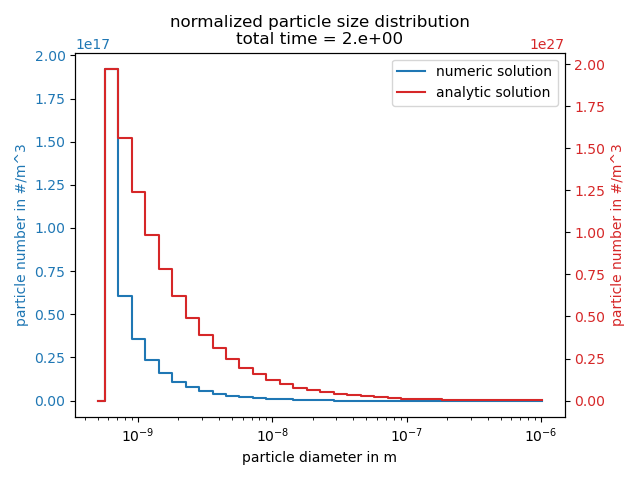

In [139]:
%matplotlib notebook
dp_start = np.zeros((vp_num))
dp_end = np.zeros((vp_num))
dp_start = (6/np.pi * vp[start_bin])**(1/3)
dp_end = (6/np.pi * vp)**(1/3)

fig, ax1 = plt.subplots()
color1 = "tab:blue"
ax1.semilogx(dp_end, n, drawstyle="steps-mid", \
             label="numeric solution", color = color1) 
ax1.set_ylabel("particle number in #/m^3", color = color1)
ax1.tick_params(axis="y", labelcolor = color1)
title_string = "normalized particle size distribution" + "\n" + \
    "total time = " + \
    str(np.format_float_scientific(t_total, precision=0))
ax1.set_title(title_string)
ax1.set_xlabel("particle diameter in m")

color2 = "tab:red"
ax2 = ax1.twinx() 
ax2.semilogx(dp_end, n_an, drawstyle="steps-mid", \
             label="analytic solution", color = color2) 
ax2.set_ylabel("particle number in #/m^3", color = color2)
ax2.tick_params(axis="y", labelcolor = color2)
#ax2.set_ylim(1.2e24,1.22e24)


# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.tight_layout()
plt.show()